In [1]:
%matplotlib inline
import numpy as np
import sklearn.decomposition
import sklearn.feature_extraction
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import bottleneck as bn
import itertools
from sklearn.cross_validation import KFold
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("poster")

###Multi-Purpose Functions for Evaluating Models
We can start by defining a couple of generally useful functions to evaluate the correctness of any given set of predictions.

In [2]:
# computes % accuracy rate of predictions, given a vector of predicted categories and a vector of actual categories
def accuracy(predicted,actual):
    # boolean array of Trues for correct predictions and Falses for incorrect predictions
    correct = map(lambda (c1,c2) : c1==c2, zip(predicted,actual))
    return float(sum(correct)) / len(correct)

We refer to a pair of documents as a true positive ($tp$) if the two documents end up in the same cluster correctly, a true negative ($tn$) if the documents end up in different clusters correctly, a false positive ($fp$) if the documents are placed in the same cluster but should have been in different clusters, and a false negative ($fn$) if the documents are placed in different clusters but should have been in the same cluster.

The Rand Index (measuring the similarity between the NMF clustering and the SCDB categories) is defined as $\frac{tp+tn}{tp+tn+fp+fn}$. This is a useful measure of the quality of an unsupervised algorithm like NMF or k-means; accuracy is harder to interpret exactly because unsupervised algorithm does not use the training set categories to generate clusters.

In [3]:
# computes the Rand Index, given a vector of predicted categories and a vector of actual categories
def rand_index(predicted,actual):
    # use itertools to create pairs of documents, using the NMF clusters and SCDB categories
    cluster_pairs_pred = itertools.product(predicted,predicted)
    cluster_pairs_actual = itertools.product(actual,actual)
    # loop through all document pairs to compute tp, tn, fp, and fn
    (tp,tn,fp,fn) = 0, 0, 0, 0
    for pair1,pair2 in zip(cluster_pairs_pred, cluster_pairs_actual):
        if (pair1[0]==pair1[1]):
            if (pair2[0]==pair2[1]):
                tp += 1
            else:
                fp += 1
        else:
            if (pair2[0]==pair2[1]):
                fn += 1
            else:
                tn += 1
    
    # compute and output Rand Index using formula from above
    rand_index_train = float(tp+tn)/(tp+tn+fp+fn)
    return rand_index_train

###Fitting Noun Model with Training Data

We'll start by fitting a model that only uses nouns, with the training data. To start with, we read in the matrix of noun training data, and apply a <a href="https://en.wikipedia.org/wiki/Tf%E2%80%93idf">TF-IDF</a> (term frequency-inverse document frequency) transformation, which places a lower weight on words that show up very frequently across all of the documents (e.g. 'case' and 'court'). This enables more meaningful clustering, by downweighting words that couldn't be used to discriminate between topics very effectively.

In [4]:
%%time
# read in training data from csv
noun_train_mat = np.loadtxt("noun_train_mat.csv", delimiter = ",")
# use TF-IDF to scale each document's vector to have norm 1 and place a lower weight on very common words
tf_idf_fit = sklearn.feature_extraction.text.TfidfTransformer().fit(noun_train_mat)
noun_train_mat = tf_idf_fit.transform(noun_train_mat).toarray()

Wall time: 33.3 s


Next, we can fit an NMF model on the matrix computed above. For evaluating the NMF method initially, we can just use 14 components, since the Supreme Court Database (SCDB) uses 14 categories for its cases.

To assign a case to a cluster, we look at the the row of the `W` matrix corresponding to that case; this $1 \times 14$ row contains a coefficient corresponding to how well the case corresponds to each one of the 14 clusters. We assign the case to a cluster by choosing the highest coefficient in that row.
Then, we can construct a list called `clusters` that contains the cluster assignments for each case.

In [6]:
%%time
# compute NMF fit
NMF_fit = sklearn.decomposition.NMF(n_components=14, init='nndsvda').fit(noun_train_mat)
H = NMF_fit.components_
W = NMF_fit.transform(noun_train_mat)
# contains a tuple (i,j) if document i is in cluster j, for each document
clusters = map(np.argmax, W)
# list of the documents in each cluster
cluster_lists = [[i for i,j in enumerate(clusters) if j==cluster] for cluster in range(14)]

Wall time: 54.3 s



C:\Users\Madhu\Anaconda\lib\site-packages\sklearn\decomposition\nmf.py:532: UserWarning: Iteration limit reached during fit. Solving for W exactly.
  warnings.warn("Iteration limit reached during fit. Solving for W exactly.")


In [26]:
# classify each document into the category that fits it best
print 'Number of documents per category:', [sum([x==i for x in clusters]) for i in range(14)]

Number of documents per category: [121, 83, 72, 35, 118, 61, 93, 25, 38, 78, 76, 72, 52, 163]


###Key Words for Each Cluster

Using the clusters from above, we can use the `H` matrix to find out which words are the strongest predictors for each cluster. In this case, for each of the 14 rows of `H` we output the words corresponding to the 5 largest elements of that row, to understand the 5 words that best represent the corresponding cluster.

In [8]:
# load noun vocab from csv
noun_vocab = np.loadtxt("noun_vocab.csv", delimiter=",", dtype="str")
noun_vocab = [(int(i),j) for i,j in noun_vocab]
id2noun = dict(noun_vocab)

In [9]:
# find and output the 5 most important words for each category
num_best = 5
best_indices = map(lambda v : list(bn.argpartsort(-v,num_best)[0:num_best]), H)
best_words = [[id2noun[i] for i in lst] for lst in best_indices]
best_words

[['claim', 'appeal', 'district', 'court', 'jurisdiction'],
 ['labor', 'union', 'employee', 'board', 'employer'],
 ['tax', 'property', 'income', 'revenue', 'state'],
 ['student', 'board', 'school', 'plan', 'education'],
 ['plan', 'benefit', 'security', 'act', 'employee'],
 ['land', 'water', 'act', 'tribe', 'reservation'],
 ['trial', 'court', 'counsel', 'petitioner', 'state'],
 ['decree', 'master', 'orig ', 'u s ', 'entry'],
 ['alien', 'immigration', 'attorney', 'deportation', 'general'],
 ['gas', 'commission', 'commerce', 'carrier', 'price'],
 ['jury', 'trial', 'evidence', 'verdict', 'petitioner'],
 ['conviction', 'sentence', 'punishment', 'offense', 'crime'],
 ['search', 'warrant', 'officer', 'police', 'respondent'],
 ['state', 'opinion', 'amendment', 'law', 'post']]

In [10]:
# can probably ignore this stuff -- it's a different way to figure out the best words in each category, but it's not working
# and produces nonsense
width = len(M[0])
best_words = np.zeros(14)
for i in range(14):
    # arbitrary high initial value
    w = np.ones(width) * 5000
    #w_val = np.ones(width)
    for j in range(width):
        for k in range(14):
            if i <> k and H[k][j] > 0:
                if w[j] >= float(H[i][j])/H[k][j]:
                    w[j] = float(H[i][j])/H[k][j]
    best_words[i] = np.argmax(w)
print map(lambda x : id2noun[int(x)], best_words)

NameError: name 'M' is not defined

###Comparing with Supreme Court Database's Topic Areas

For now, we have been using an unsupervised algorithm that ignores the Supreme Court Database data altogether. To analyze and evaluate the performance of the algorithm, we need to include the data from the Supreme Court Database, which provides a category for each Supreme Court case.

In [11]:
# read in SC Database's issue areas from csv
train_issue_areas = np.loadtxt("train_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
train_issue_areas = train_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in train_issue_areas]) for i in range(14)]

# convert the nx1 issue areas vector into a nx14 matrix of dummies, in case that's ever useful
train_issue_areas_dummy = np.array(map(lambda area : np.eye(1,14,area)[0], train_issue_areas))

Number of documents per category: [238, 186, 84, 43, 10, 9, 56, 234, 126, 57, 10, 30, 4, 0]


These are the 14 topic areas that the Supreme Court Database uses, in order.

In [12]:
topic_areas = ['Criminal Procedure', 'Civil Rights', 'First Amendment', 'Due Process', 'Privacy', 'Attorneys', 'Unions',
               'Economic Activity', 'Judicial Power', 'Federalism', 'Interstate Relations', 'Federal Taxation', 'Miscellaneous',
               'Private Action']

The unsupervised NMF algorithm has given us 14 clusters, but these 14 clusters don't map perfectly to the 14 SCDB clusters. We need a way to take the NMF cluster assignment for any particular case and convert it into the SCDB category that fits the case best. In particular, we need a way to map each NMF cluster to a particular SCDB category. There are multiple ways to do this, which are examined below.

####Assignment method 1: use the cluster assignments computed above to find the best SCDB category match
This method works as follows: For each NMF cluster from above, assign that cluster to the SCDB category that has the most cases in common with the NMF cluster.

We construct an `assignments` array, such that if `assignments[i]==j`, then NMF cluster `i` gets mapped to SCDB category `j`. Note that this is not a one-to-one mapping; in other words, multiple NMF clusters can get mapped to the same SCDB category, and some SCDB categories might not be reached at all.

This is the method that tends to work best in terms of accuracy rate and Rand index, so if you are running this code, you should probably stop here instead of running the code for the two assignment methods below.

In [27]:
# create a 14x14 matrix (where each row is an NMF cluster and each column is an SCDB cluster) measuring the degree of
# related-ness between each cluster pair
compare_mat = map(lambda r : map(int, r), np.zeros((14,14)))
# first, assign the (i,j) element in the matrix to the number of cases in NMF cluster i and SCDB cluster j, for each (i,j)
for i,j in zip(clusters, train_issue_areas):
    compare_mat[i][j] += 1
# normalize each row to have a sum of 1
compare_mat = map(lambda row : map(float,row) / sum(row), np.array(compare_mat))

# assign each NMF cluster to a (not necessarily unique) SCDB cluster by picking the highest element of each row of compare_mat
assignments = map(np.argmax, compare_mat)
print assignments

[8, 6, 7, 1, 7, 7, 0, 10, 1, 7, 0, 0, 0, 2]


####Assignment method 2: use the rows of the W matrix (from NMF) to find the best SCDB category match for each cluster
This is the same basic idea as above; however, temporarily, instead of just thinking of each case as getting assigned to a single cluster (as we did above), we can take a $1 \times 14$ row vector of coefficients for each case from the W matrix (representing how well that case falls into each cluster).

In [14]:
# Difference compared to above: Instead of just thinking of each case as getting assigned to a single cluster (as we did above),
# we can think of each case as having a coefficient for each cluster (from the W matrix), and increment entries of compare_mat
# using those coefficients instead of just incrementing by 1.

# create a 14x14 matrix (where each row is an SCDB cluster and each column is an NMF cluster) measuring the degree of
# related-ness between each cluster pair
compare_mat = np.zeros((14,14))
for i,j in zip(W, train_issue_areas):
    # increment the jth row of compare_mat by the entire row of W corresponding to the current case
    compare_mat[j] = compare_mat[j] + i
# transpose that matrix (so that it's in the same format as the matrix in assignment method 1 above)
compare_mat = compare_mat.T

# assign each NMF cluster to a (not necessarily unique) SCDB cluster by picking the highest element of each row of compare_mat
assignments = map(np.argmax, compare_mat)
print assignments

[8, 6, 7, 1, 7, 7, 0, 9, 1, 7, 0, 0, 0, 1]


####Assignment method 3: use Hungarian algorithm (which computes assignments that minimize cost) to assign each NMF cluster to an SCDB cluster (without any collisions)
This final method uses the <a href="https://en.wikipedia.org/wiki/Hungarian_algorithm">Hungarian algorithm</a>, which takes a matrix of 'costs' and produces the optimal one-to-one assignment of rows to columns. The benefit of this algorithm is that it maps every NMF cluster to exactly one SCDB category; however, this method ultimately produces much a lower accuracy rate and Rand index, so it is not worth using.

In [15]:
### NOTE: probably don't run this -- it generates assignments that have very low accuracy
import munkres
m = munkres.Munkres()
assignments = dict(m.compute(-np.array(compare_mat)))
print assignments

{0: 8, 1: 6, 2: 11, 3: 12, 4: 3, 5: 9, 6: 0, 7: 10, 8: 1, 9: 7, 10: 5, 11: 13, 12: 4, 13: 2}


####Assign an SCDB category to each case, using an assignment array created above
Using an assignment method from above, we can convert the NMF clusters produced from the model above into an assignment of each case to an SCDB topic area. We can then produce the accuracy rate (defined as the proportion of cases that are assigned to the correct SCDB category).

In [52]:
# use the assignments above to convert the clusters into equivalent SCDB categories for each document
new_clusters = map(lambda cluster : assignments[cluster], clusters)
# compute and output accuracy rate
print 'Accuracy:', accuracy(new_clusters, train_issue_areas)

Accuracy: 0.500459981601


The following heat map shows the output of the clustering above, on the training data. Each row corresponds to a predicted category, and each column corresponds to an actual category. The value in row `i` and column `j` is the number of cases that were in SCDB category `j` and got assigned to category `i` above. The elements on the main diagonal refer to correct predictions.

An important note here is that some of the SCDB categories weren't covered at all; for instance, none of the cases got clustered into due process, privacy, or federal taxation above. The cases in those categories got lumped into other (usually similar) categories).

In [ ]:
compare_mat_new = map(lambda r : map(int, r), np.zeros((14,14)))
for i,j in zip(new_clusters, train_issue_areas):
    compare_mat_new[i][j] += 1
sns.heatmap(compare_mat_new, annot=True, xticklabels=topic_areas, yticklabels=topic_areas, fmt='d')
sns.axlabel('SCDB Category', 'Predicted Category')

The next heat map is similar, but normalizes each column to have a sum of 1. In other words, the element in row `i` and column `j` represents the proportion of cases from SCDB category `j` that get placed in category `i` by the NMF clustering algorithm.

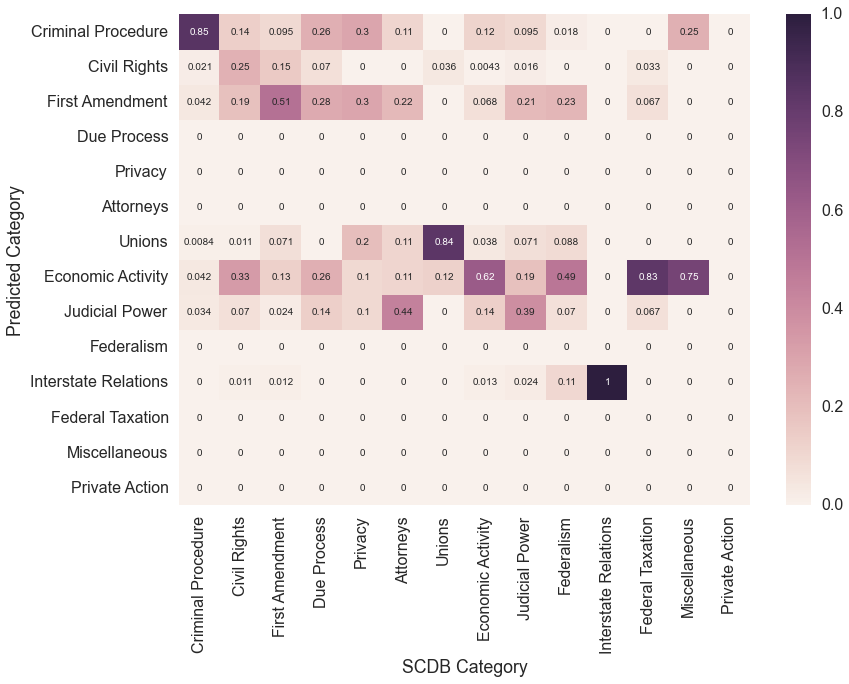

In [45]:
# normalize each column to have a sum of 1
compare_mat_new = np.array(compare_mat_new).T
compare_mat_new = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(compare_mat_new))
compare_mat_new = np.array(compare_mat_new).T

# produce a heat map of the new normalized matrix
sns.heatmap(compare_mat_new, annot=True, xticklabels=topic_areas, yticklabels=topic_areas)
sns.axlabel('SCDB Category', 'Predicted Category')

The heat map gives some useful information about the errors that the NMF algorithm above tends to make most frequently. For example, many civil rights and federal taxation cases get mis-classified as economic activity cases; many due process cases get mis-classified as first amendment or civil rights cases; and many attorneys cases get mis-classified as judicial power cases.

The following bar graph displays the accuracy rate of the NMF clustering for the cases within each SCDB category, for the training data.

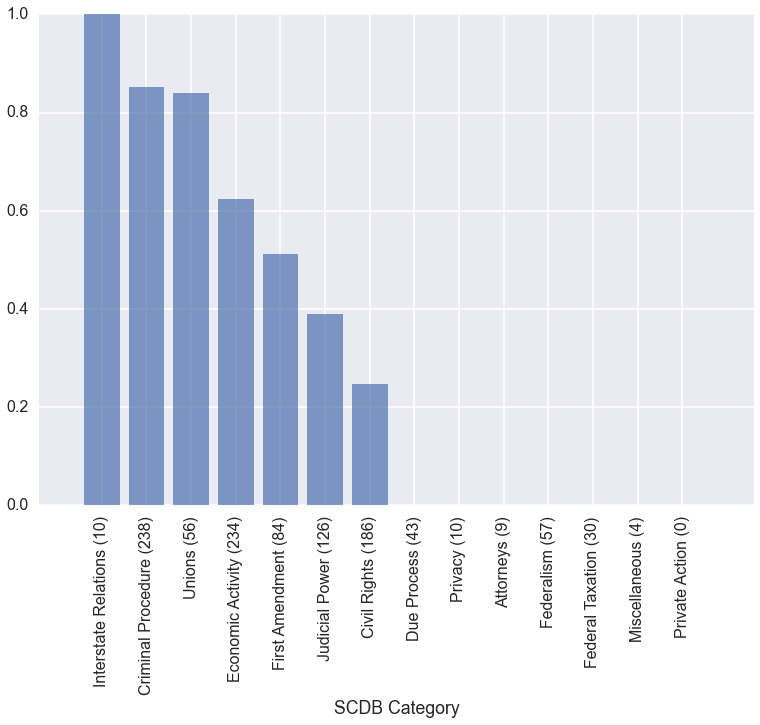

In [47]:
# sort the SCDB topic areas based on accuracy on training data
ordered = zip(topic_areas, [sum([x==i for x in train_issue_areas]) for i in range(14)], np.diag(compare_mat_new), range(14))
ordered.sort(key = lambda (topic,num,acc,ind) : -acc)
ordered_topics = list(zip(*ordered)[0])
counts = list(zip(*ordered)[1])
topic_accuracies = list(zip(*ordered)[2])
order = list(zip(*ordered)[3])

# plot a bar chart of the accuracy of the clustering algorithm within each topic area
fig, ax = plt.subplots()
ax.bar(np.arange(14)+1, topic_accuracies, alpha=0.7, linewidth=0)

ax.set_xticks(np.arange(14)+1.4)
ax.set_xticklabels(map(lambda (count,topic) : "%s (%s)" % (topic,count), zip(counts,ordered_topics)), rotation='vertical')
ax.set_xlabel('SCDB Category')
print

This bar chart has both good and bad news. The NMF algorithm tends to do well for many of the categories; in particular, it does reasonably well on most of the largest categories, such as criminal procedures and economic activity. Unfortunately, the accuracy is much lower for some other categories, and there are several categories that have a 0% accuracy rate because the algorithm assigns zero cases to those categories.

###Use Rand Index to Evaluate Model on Training Data

Now, we can use the Rand Index (defined above) to evaluate how well the model does with the training data.

#NOTE: FIX THIS BY USING THE RAND_INDEX FUNCTION 

In [50]:
print rand_index(new_clusters, train_issue_areas)

0.780644211214


###Cross-Validation

In [22]:
def cv_results_unsupervised(predict, x, y, score_func, nfolds=5):
    results = []
    for train, test in KFold(len(y), nfolds):
        pred = predict(x[train],y[train],x[test])#clf.fit(x[train]).transform(x[test])
        results += [score_func(pred, y[test])] # evaluate score function on held-out data
    return results

In [23]:
# Fits an NMF model with n_components clusters on the data in x_train and y_train, and use that to predict clusters for x_test.
# (Since NMF is unsupervised, the data in y_train is only used to create a mapping from NMF clusters to SCDB clusters, not to
# actually fit the model.)
def fit_transform(x_train, y_train, x_test, n_components):
    # compute an NMF fit on x_train, and produce
    fit = sklearn.decomposition.NMF(n_components=n_components, init='nndsvda').fit(x_train)
    W_train = fit.transform(x_train)
    clusters_train = map(np.argmax, W_train)
    
    # create a 14x14 matrix (where each row is an NMF cluster and each column is an SCDB cluster) measuring the degree of
    # related-ness between each cluster pair
    compare_mat = map(lambda r : map(int, r), np.zeros((n_components,14)))
    # first, assign the (i,j) element in the matrix to the number of cases in NMF cluster i and SCDB cluster j, for each (i,j)
    for i,j in zip(clusters_train, y_train):
        compare_mat[i][j] += 1
    assignments = map(np.argmax, compare_mat)
    
    W_test = fit.transform(x_test)
    clusters_test = map(np.argmax, W_test)
    # use the assignments above to convert the clusters into equivalent SCDB categories for each document
    new_clusters = map(lambda cluster : assignments[cluster], clusters_test)
    return new_clusters

In [25]:
%%time
num_clusters_lst = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

results = dict()
for k in num_clusters_lst:
    print 'Testing with %d clusters' % k
    results[k] = cv_results_unsupervised(lambda x,y,z : fit_transform(x,y,z,k), noun_train_mat, train_issue_areas,
                                         lambda pred,act : (accuracy(pred,act), rand_index(pred,act)), nfolds=5)

Testing with 5 clusters
Testing with 10 clusters
Testing with 15 clusters
Testing with 20 clusters
Testing with 25 clusters
Testing with 30 clusters
Testing with 35 clusters
Testing with 40 clusters
Testing with 45 clusters
Testing with 50 clusters
Wall time: 59min 40s


In [28]:
results_accuracies = dict()
results_rand_ind = dict()
for k in results.keys():
    accuracy_k, rand_index_k = zip(*results[k])
    results_accuracies[k] = np.mean(accuracy_k)
    results_rand_ind[k] = np.mean(rand_index_k)
print results_accuracies
print results_rand_ind

{35: 0.49764934680590206, 5: 0.4378768020969856, 40: 0.48207838329176, 10: 0.46172578531264535, 45: 0.48846657929226733, 15: 0.49123155625079279, 50: 0.50596541664905081, 20: 0.49118927831564713, 25: 0.48106794064177905, 30: 0.49397116644823064}
{35: 0.75952458809582646, 5: 0.66749798413003247, 40: 0.75769849213053331, 10: 0.73717176511222893, 45: 0.76328322379484914, 15: 0.77671859372916785, 50: 0.77692147151401725, 20: 0.77216563028945062, 25: 0.76275710596632429, 30: 0.76414665512708246}


##Choose Best Model and Run on Test Data

###Choose Optimal Number of Clusters and Categorize Test Data

####Option 1: Choose optimal n_clusters using average accuracy rate

In [29]:
n_clusters = results_accuracies.keys()[np.argmax(results_accuracies.values())]
n_clusters

50

####Option 2: Choose optimal n_clusters using average Rand Index

In [30]:
n_clusters = results_rand_ind.keys()[np.argmax(results_rand_ind.values())]
n_clusters

50

###Fit Model with Optimal Parameter and Apply to Test Data

In [31]:
%%time
# read in test data from csv
noun_test_mat = np.loadtxt("noun_test_mat.csv", delimiter = ",")
# use TF-IDF fit from training data to scale each document's vector to have norm 1 and place a lower weight on very common words
noun_test_mat = tf_idf_fit.transform(noun_test_mat).toarray()

Wall time: 13.7 s


In [32]:
%%time
clusters_test = fit_transform(noun_train_mat, train_issue_areas, noun_test_mat, n_clusters)
cluster_lists_test = [[i for i,j in enumerate(clusters_test) if j==cluster] for cluster in range(14)]

Wall time: 2min 33s


###Evaluate Test Data Results Using SC Database Categories

In [33]:
# read in SC Database's issue areas from csv
test_issue_areas = np.loadtxt("test_issue_areas.csv", delimiter = ",", dtype="int")
# zero-index the array
test_issue_areas = test_issue_areas - 1
print 'Number of documents per category:', [sum([x==i for x in test_issue_areas]) for i in range(14)]

Number of documents per category: [104, 97, 38, 15, 3, 6, 26, 104, 68, 24, 5, 17, 1, 0]


In [34]:
print 'Accuracy:', accuracy(clusters_test, test_issue_areas)
print 'Rand Index:', rand_index(clusters_test, test_issue_areas)

Accuracy: 0.474409448819
Rand Index: 0.753751007502


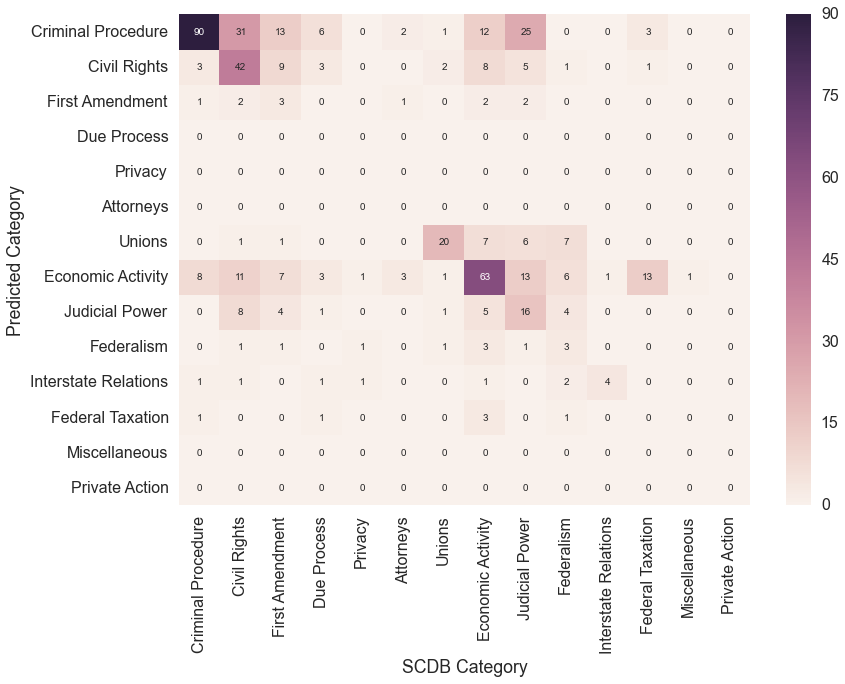

In [35]:
compare_mat_test = map(lambda r : map(int, r), np.zeros((14,14)))
for i,j in zip(clusters_test, test_issue_areas):
    compare_mat_test[i][j] += 1

sns.heatmap(compare_mat_test, annot=True, xticklabels=topic_areas, yticklabels=topic_areas, fmt='d')
sns.axlabel('SCDB Category', 'Predicted Category')

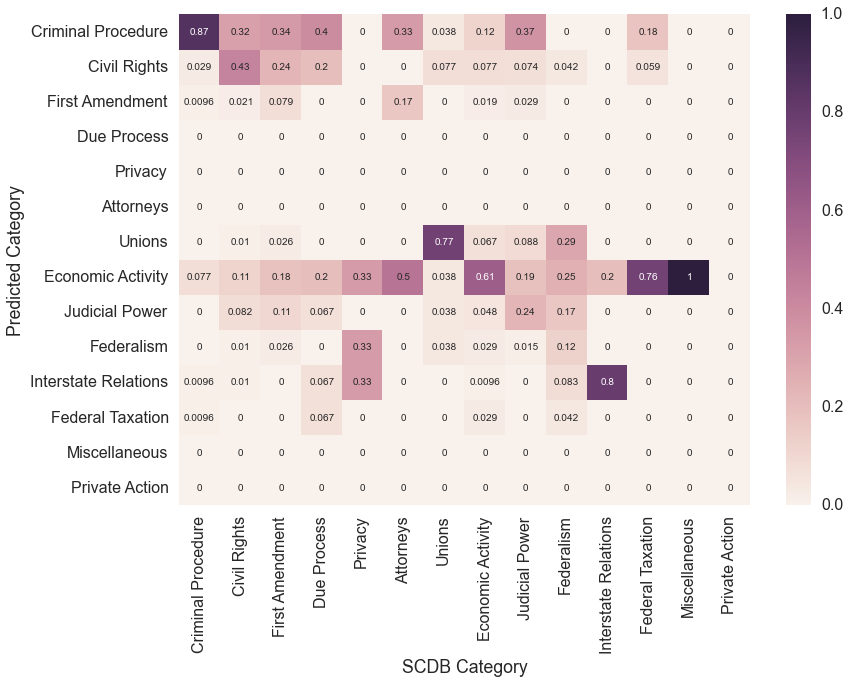

In [36]:
# normalize each column to have a sum of 1
compare_mat_test = np.array(compare_mat_test).T
compare_mat_test = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(compare_mat_test))
compare_mat_test = np.array(compare_mat_test).T

# produce a heat map in which the element in row i and column j represent the proportion of cases in the testing set from SCDB
# category j that get placed in category i by the clustering algorithm (trained on the training data with the optimal parameter)
sns.heatmap(compare_mat_test, annot=True, xticklabels=topic_areas, yticklabels=topic_areas)
sns.axlabel('SCDB Category', 'Predicted Category')

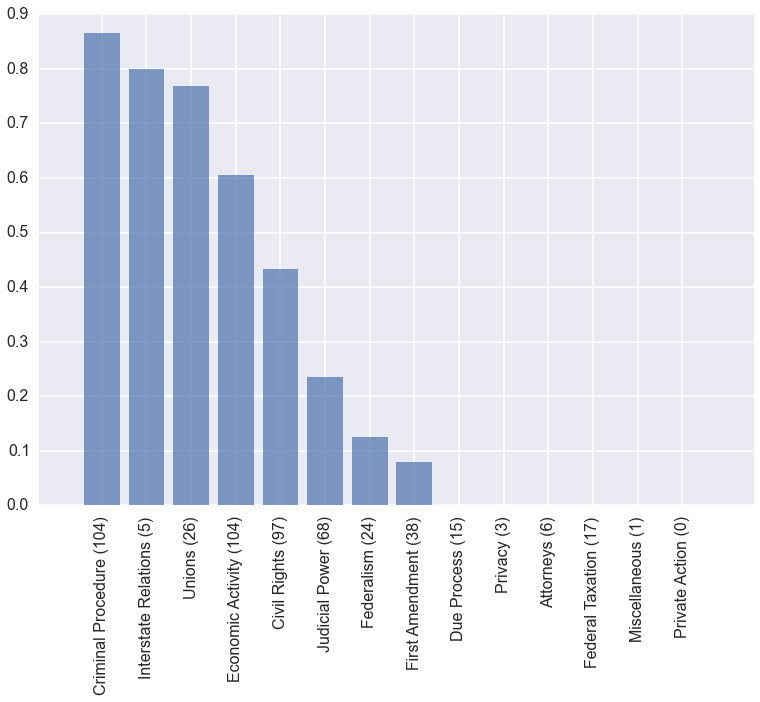

In [37]:
# sort the SCDB topic areas based on accuracy on testing data
ordered = zip(topic_areas, [sum([x==i for x in test_issue_areas]) for i in range(14)], np.diag(compare_mat_test), range(14))
ordered.sort(key = lambda (topic,num,acc,ind) : -acc)
ordered_topics = list(zip(*ordered)[0])
counts = list(zip(*ordered)[1])
topic_accuracies = list(zip(*ordered)[2])
order = list(zip(*ordered)[3])

# plot a bar chart of the accuracy of the clustering algorithm within each topic area
fig, ax = plt.subplots()
ax.bar(np.arange(14)+1, topic_accuracies, alpha=0.7, linewidth=0)

ax.set_xticks(np.arange(14)+1.4)
ax.set_xticklabels(map(lambda (count,topic) : "%s (%s)" % (topic,count), zip(counts,ordered_topics)), rotation='vertical')
ax.set_xlabel('SCDB Category')
print

###Trying Other Parts of Speech

In [38]:
def evaluate(x_files, y_data, n_clusters):
    # read in text data
    x_data = map(lambda x_file : np.loadtxt(x_file, delimiter=','), x_files)
    x_data = reduce(lambda x1,x2 : np.concatenate((x1,x2),1), x_data)
    
    # use TF-IDF to scale each document's vector to have norm 1 and place a lower weight on very common words
    tf_idf_fit = sklearn.feature_extraction.text.TfidfTransformer().fit(x_data)
    x_data = tf_idf_fit.transform(x_data).toarray()
    
    # compute NMF fit
    NMF_fit = sklearn.decomposition.NMF(n_components=n_clusters, init='nndsvda').fit(x_data)
    H = NMF_fit.components_
    W = NMF_fit.transform(x_data)
    # contains a tuple (i,j) if document i is in cluster j, for each document
    clusters = map(np.argmax, W)
    
    # create a 14x14 matrix (where each row is an NMF cluster and each column is an SCDB cluster) measuring the degree of
    # related-ness between each cluster pair
    compare_mat = map(lambda r : map(int, r), np.zeros((n_clusters,14)))
    # first, assign the (i,j) element in the matrix to the number of cases in NMF cluster i and SCDB cluster j, for each (i,j)
    for i,j in zip(clusters, y_data):
        compare_mat[i][j] += 1
    # normalize each row to have a sum of 1
    compare_mat = map(lambda row : map(float,row) / sum(row) if sum(row) > 0 else map(float,row), np.array(compare_mat))

    # assign each NMF cluster to a SCDB cluster by picking the highest element of each row of compare_mat
    assignments = map(np.argmax, compare_mat)
    
    # use the assignments above to convert the clusters into equivalent SCDB categories for each document
    new_clusters = map(lambda cluster : assignments[cluster], clusters)
    
    return (accuracy(new_clusters, y_data), rand_index(new_clusters, y_data))

In [40]:
%%time
evaluate(['noun_train_mat.csv','verb_train_mat.csv','adj_train_mat.csv','for_train_mat.csv','prec_train_mat.csv'],
         train_issue_areas, n_clusters=n_clusters)

Wall time: 4min 22s


(0.546458141674333, 0.7942464638121007)

In [41]:
%%time
evaluate(['noun_train_mat.csv','verb_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 5min


(0.5390984360625575, 0.7776651215460121)

In [42]:
%%time
evaluate(['noun_train_mat.csv','adj_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 3min 47s


(0.5206991720331187, 0.7647263934649605)

In [43]:
%%time
evaluate(['noun_train_mat.csv','prec_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 3min 40s


(0.5271389144434223, 0.7688801923544033)

In [44]:
%%time
evaluate(['verb_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

Wall time: 1min 24s


(0.39282428702851885, 0.7066002916461078)

In [ ]:
%%time
evaluate(['adj_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

In [ ]:
%%time
evaluate(['for_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)

In [ ]:
%%time
evaluate(['prec_train_mat.csv'], train_issue_areas, n_clusters=n_clusters)